In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Ellipse
import scipy.optimize as op
import emcee
from corner import corner

In [2]:
def _ellipse(x, y, cov, scale=2, **kwargs):
    vals, vecs = np.linalg.eig(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = scale * np.sqrt(vals)

    kwds = dict(lw=0.5, color= 'r')
    kwds.update(**kwargs)

    ellipse = Ellipse(xy=[x, y], 
                      width=w, height=h, angle=theta,
                      **kwds)
    ellipse.set_facecolor("none")
    return ellipse

In [3]:
def generate_data(student_id):
    
    N = 20
    x_low, x_high = (0, 500)
    y_low, y_high = (0, 1000)
    
    np.random.seed(student_id) #reproducability
    
    m = np.tan(np.arcsin(np.random.uniform(-1, 1)))
    
    x_transform = lambda x: x * (x_high - x_low) + x_low
    y_transform = lambda y: y * (y_high - y_low) + y_low
    x_true = x_transform(np.random.uniform(size=N))
    b = -1.1 * np.min(m * x_true) + np.random.normal(0, 1)
    
    y_true = m * x_true + b
    y_err_scale = 5 * (y_high - y_low) / 100
    x_err_scale = 5 * (x_high - x_low) / 50
    x_err = x_err_scale * np.random.randn(N)
    y_err = y_err_scale * np.random.randn(N)
    
    x = x_true + x_err * np.random.randn(N)
    y = y_true + y_err * np.random.randn(N)
    x_err, y_err = (np.abs(x_err), np.abs(y_err))
    rho_xy = np.random.uniform(low=-1, high=+1, size=N)
    
    N_outliers = np.random.randint(1, 5)
    outlier_indices = np.random.choice(N, N_outliers, replace=False)
    x[outlier_indices] = x_transform(np.random.uniform(size=N_outliers))
    y[outlier_indices] = y_transform(np.random.uniform(size=N_outliers))
    
    return np.vstack([x, y, x_err, y_err, rho_xy]).T

In [4]:
STUDENT_ID = 28751795
data = generate_data(STUDENT_ID)
np.savetxt("data.csv", data)

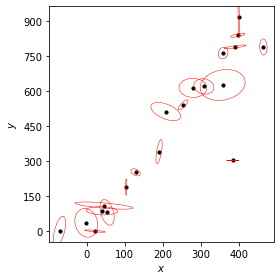

In [5]:
x, y, x_err, y_err, rho_xy = data = np.loadtxt("data.csv").T

covs = np.array([[[x_e**2, x_e*y_e*rho],
                  [x_e*y_e*rho, y_e**2]] \
                  for y_e, x_e, rho in zip(*data[2:])])

fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)

for xi, yi, cov in zip(x, y, covs):
    ax.add_artist(_ellipse(xi, yi, cov))
    

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
fig.tight_layout()

In [15]:
covs = np.array([[[x_e**2, x_e*y_e*rho],
                  [x_e*y_e*rho, y_e**2]] for y_e, x_e, rho in zip(y_err, x_err, rho_xy)])




def log_prior(theta):
    b, m, Q, mu_o, ln_sigma_v = theta
    if not (1 > Q > 0) \
    or not (700 > mu_o > 0) \
    or not (5 > ln_sigma_v > -5):
        return -np.inf
    return -3/2 * np.log(1 + m**2)


# We will describe the straight line model as 'foreground'.
def log_likelihood_fg(theta, x, y, C):
    b, m, *_ = theta
    
    V = np.array([[-m, 1]]).T
    
    Delta = (y - m * x - b)
    Sigma = (V.T @ C @ V).flatten()

    return np.sum(-np.log((Sigma)) - 0.5 * Delta**2 / Sigma)


# And the outlier model as 'background'.
def log_likelihood_bg(theta, x, y, C):
    b, m, Q, mu_o, ln_sigma_v = theta
    
    total_variance = y_err**2 + np.exp(ln_sigma_v)**2

    return -0.5 * ((y - mu_o)**2 / total_variance) - 0.5 * np.log(total_variance)

# Defining the total log-likelihood
def log_likelihood(theta,x,y,C):
    b, m, Q, mu_o, ln_sigma_v = theta
    
    ll_fg = np.log(Q) + log_likelihood_fg(theta, x, y, C)
    
    ll_bg = np.log(1 - Q) + log_likelihood_bg(theta, x, y, C)
    
    return np.sum(np.logaddexp(ll_fg, ll_bg))

#Defining the 
def log_posterior(theta, x, y, C):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return (-np.inf, np.nan * np.ones((2, x.size)))
    
    b, m, Q, mu_o, ln_sigma_v = theta
    
    ll_fg = np.log(Q) + log_likelihood_fg(theta, x, y, C)
    
    ll_bg = np.log(1 - Q) + log_likelihood_bg(theta, x, y, C)
    
    # now get the log likelihood
    ll = log_likelihood(theta,x,y,C)

    return (lp + ll, np.vstack([ll_fg, ll_bg]))

In [16]:
# get the linalg solutions for the parameters!


Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)

C_inv = np.linalg.inv(C)

G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

b, m = X.T[0]

print('The linear algebra solution for the staright line model is')
print('b = ',b,'m = ',m)



The linear algebra solution for the staright line model is
b =  -51.44402952631049 m =  2.354951057607506


In [17]:
#Optimize using the linalg solutions and rough estimates for the misc parameters 
args = (x, y, covs)
initial_theta = np.array([b,m, 0.5, 400, -3])

result = op.minimize(
    lambda *args: -log_posterior(*args)[0],
    initial_theta,
    args=args,
    method="L-BFGS-B",
    bounds=[
        (None, None),
        (None, None),
        (0, 1),
        (0, 100000),
        (-5, 5)
    ]
)

print(result)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 20

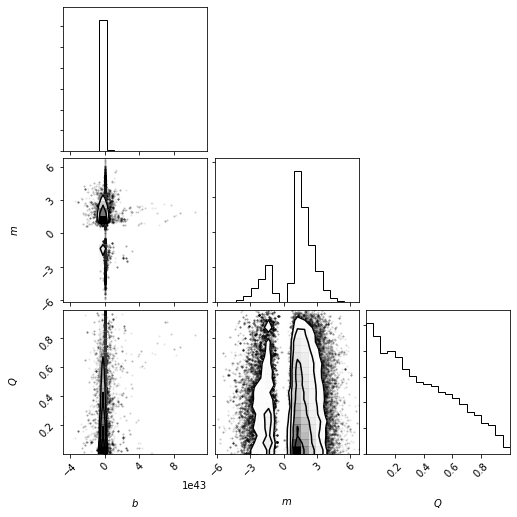

In [65]:

# Sample!
ndim, nwalkers = (result.x.size, 64)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# Run the burn-in.
pos, *_ = sampler.run_mcmc(p0, 1000)
sampler.reset()

# Run production.
sampler.run_mcmc(pos, 2000)

# Make a corner plot just showing m, b, Q
chain = sampler.chain.reshape((-1, ndim))

fig = corner(
    chain[:, :3],
    labels=(r"$b$", r"$m$", r"$Q$"),
)

plt.savefig('q5_figure')

In [57]:
# get q values for data points 
q = np.zeros_like(x)
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[0]):
        ll_fg, ll_bg = sampler.blobs[i][j]
        q += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
  
q /= np.prod(sampler.chain.shape[:2])

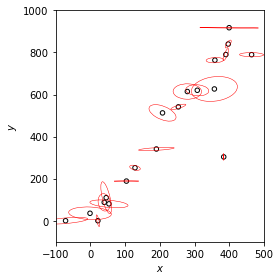

In [58]:
from matplotlib.ticker import MaxNLocator

# Make posterior predictions.
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=q, edgecolor="k", lw=1, cmap="Greys", s=20)


xlim = np.array([-100, 500])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
# Plot draws of the posterior.
for index in np.random.choice(chain.shape[0], size=100):
    b, m = chain[index, :2]
    ax.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:orange",
        alpha=0.2,
        lw=0.5,
        zorder=-100
    )

for xi, yi, cov in zip(x, y, covs):
    ax.add_artist(_ellipse(xi, yi, cov))    
    
ax.set_xlim(*xlim)
ax.set_ylim(-100, 1000)

plt.savefig('q6_figure')

fig.tight_layout()


